In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPy.models import GPRegression
from GPy.kern import RBF
from scipy.optimize import minimize
from NSGPy.NumPy import LLS
from polire.interpolate import Idw, BSpline, Kriging, Natural_neighbor, SpatialAverage, Trend
import seaborn as sns

## Delhi

In [2]:
data = pd.read_csv('../../data/delhi/delhi-filtered/SpatialCleanAll.csv')
data = data.set_index('utc').sort_index()
data.shape, data.shape[0]/30

((7260, 5), 242.0)

In [3]:
ts = 24*3
sel_index = data.index.unique()[:ts]
sel_data = data.loc[sel_index]
print(sel_data.shape, sel_data.columns, sel_data.shape[0]/30, )

loc_df = sel_data[['location','latitude','longitude']].drop_duplicates('location').set_index('location')
loc_df.index

(2160, 5) Index(['location', 'value', 'mobile', 'latitude', 'longitude'], dtype='object') 72.0


Index(['Anand Vihar, Delhi - DPCC', 'Ashok Vihar, Delhi - DPCC',
       'Aya Nagar, Delhi - IMD', 'Bawana, Delhi - DPCC',
       'CRRI Mathura Road, Delhi - IMD', 'DTU, Delhi - CPCB',
       'Dwarka-Sector 8, Delhi - DPCC ', 'IGI Airport (T3), Delhi - IMD',
       'IHBAS, Dilshad Garden, Delhi - CPCB', 'ITO, Delhi - CPCB',
       'Jahangirpuri, Delhi - DPCC', 'Jawaharlal Nehru Stadium, Delhi - DPCC',
       'Lodhi Road, Delhi - IMD', 'Mundka, Delhi - DPCC',
       'NSIT Dwarka, Delhi - CPCB', 'Najafgarh, Delhi - DPCC',
       'Narela, Delhi - DPCC', 'Nehru Nagar, Delhi - DPCC',
       'Okhla Phase-2, Delhi - DPCC', 'Patparganj, Delhi - DPCC',
       'Punjabi Bagh, Delhi - DPCC', 'R K Puram, Delhi - DPCC',
       'Rohini, Delhi - DPCC', 'Shadipur, Delhi - CPCB',
       'Sirifort, Delhi - CPCB', 'Sonia Vihar, Delhi - DPCC',
       'Sri Aurobindo Marg, Delhi - DPCC', 'US Diplomatic Post: New Delhi',
       'Vivek Vihar, Delhi - DPCC', 'Wazirpur, Delhi - DPCC'],
      dtype='object', name=

In [4]:
multi_data = pd.crosstab(sel_data.index, sel_data.location, sel_data.value, aggfunc=lambda x:x)
multi_data.shape

(72, 30)

### Longitude

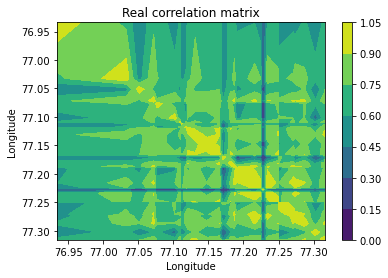

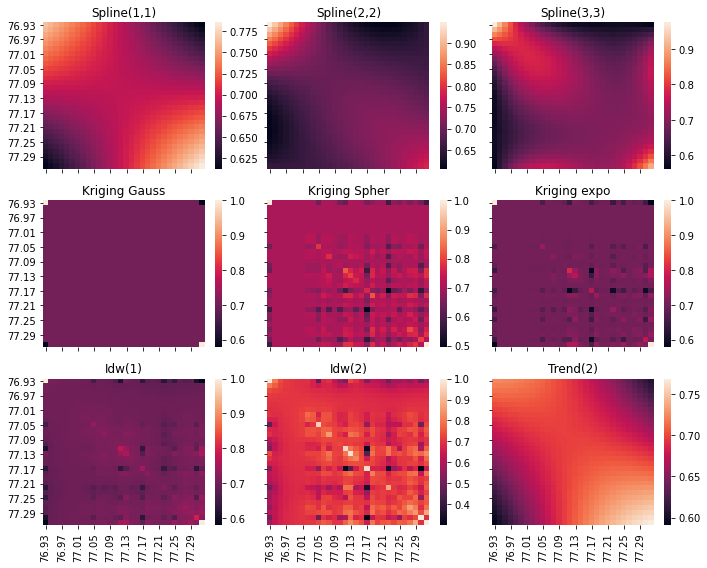

In [5]:
feature = 'Longitude'
x_real = loc_df[feature.lower()].values
x_uniform = np.linspace(x_real.min(), x_real.max(), 30)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
tmp_df = pd.DataFrame(index=x_real, columns=x_real, data=multi_data.corr().values)
# print(tmp_df.head())
tmp_df = tmp_df.sort_index()
tmp_df = tmp_df[tmp_df.index.tolist()]
# print(tmp_df.head())
x_real = np.array(sorted(loc_df[feature.lower()].values))
X1_real, X2_real = np.meshgrid(x_real, x_real)
plt.contourf(X1_real, X2_real, tmp_df.values)
plt.xlabel(feature);plt.ylabel(feature)
plt.gca().invert_yaxis()
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging expo',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='exponential'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
#     maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    tmp_df = pd.DataFrame(index=np.round(x_uniform,2), 
                          columns=np.round(x_uniform,2), 
                          data=Z_uniform.reshape(*X1_uniform.shape))
    sns.heatmap(tmp_df, ax=ax[locs[idx]])
#     ax[locs[idx]].set_xlabel(feature);ax[locs[idx]].set_ylabel(feature)
#     plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()

### Latitude

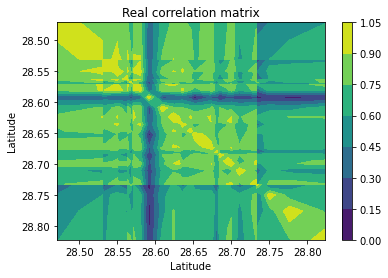

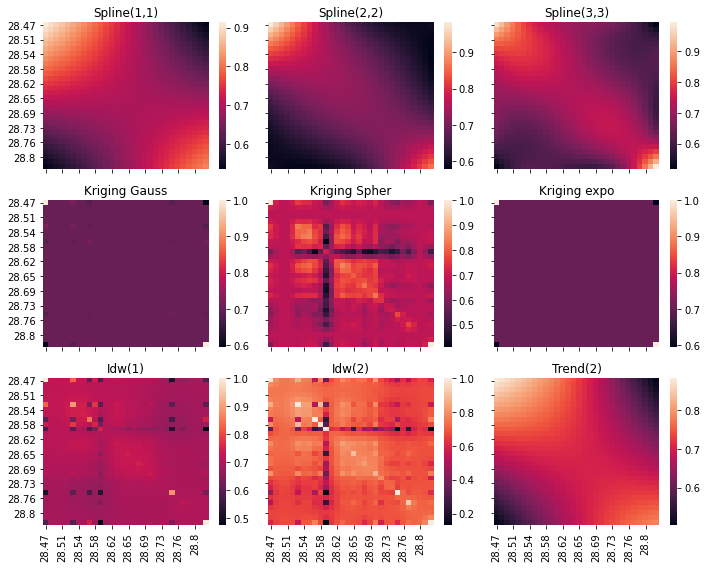

In [6]:
feature = 'Latitude'
x_real = loc_df[feature.lower()].values
x_uniform = np.linspace(x_real.min(), x_real.max(), 30)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
tmp_df = pd.DataFrame(index=x_real, columns=x_real, data=multi_data.corr().values)
# print(tmp_df.head())
tmp_df = tmp_df.sort_index()
tmp_df = tmp_df[tmp_df.index.tolist()]
# print(tmp_df.head())
x_real = np.array(sorted(loc_df[feature.lower()].values))
X1_real, X2_real = np.meshgrid(x_real, x_real)
plt.contourf(X1_real, X2_real, tmp_df.values)
plt.xlabel(feature);plt.ylabel(feature)
plt.gca().invert_yaxis()
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging expo',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='exponential'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
#     maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    tmp_df = pd.DataFrame(index=np.round(x_uniform,2), 
                          columns=np.round(x_uniform,2), 
                          data=Z_uniform.reshape(*X1_uniform.shape))
    sns.heatmap(tmp_df, ax=ax[locs[idx]])
#     ax[locs[idx]].set_xlabel(feature);ax[locs[idx]].set_ylabel(feature)
#     plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()

### Beijing

In [7]:
# ts = 24*3
data = pd.read_csv('../../data/beijing/beijing_corrected_data.csv').set_index('utc_time')
loc_df = pd.read_csv('../../data/beijing/beijing_corrected_locs.csv')

sel_index = data.index.unique()[:ts]
sel_data = data.loc[sel_index]
sel_data.shape, sel_data.shape[0]/35, sel_data.columns

((2520, 7),
 72.0,
 Index(['stationId', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2'], dtype='object'))

In [8]:
multi_data = pd.crosstab(sel_data.index, sel_data.stationId, sel_data['PM2.5'], aggfunc=lambda x:x)
multi_data.shape

(72, 35)

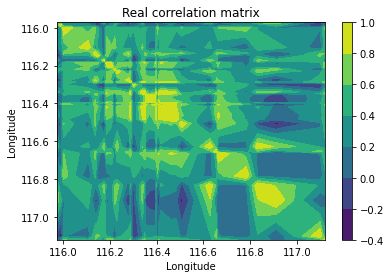

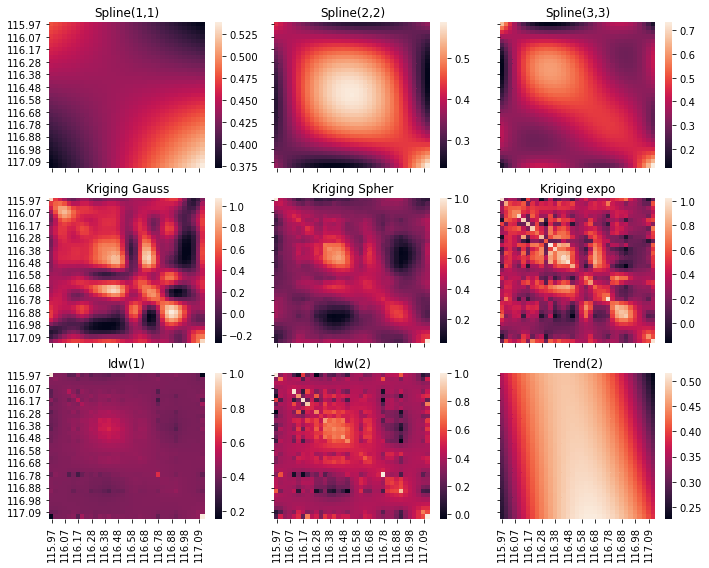

In [9]:
feature = 'Longitude'
x_real = loc_df[feature.lower()].values
x_uniform = np.linspace(x_real.min(), x_real.max(), 35)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
tmp_df = pd.DataFrame(index=x_real, columns=x_real, data=multi_data.corr().values)
# print(tmp_df.head())
tmp_df = tmp_df.sort_index()
tmp_df = tmp_df[tmp_df.index.tolist()]
# print(tmp_df.head())
x_real = np.array(sorted(loc_df[feature.lower()].values))
X1_real, X2_real = np.meshgrid(x_real, x_real)
plt.contourf(X1_real, X2_real, tmp_df.values)
plt.xlabel(feature);plt.ylabel(feature)
plt.gca().invert_yaxis()
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging expo',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='exponential'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
#     maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    tmp_df = pd.DataFrame(index=np.round(x_uniform,2), 
                          columns=np.round(x_uniform,2), 
                          data=Z_uniform.reshape(*X1_uniform.shape))
    sns.heatmap(tmp_df, ax=ax[locs[idx]])
#     ax[locs[idx]].set_xlabel(feature);ax[locs[idx]].set_ylabel(feature)
#     plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()

### Latitude

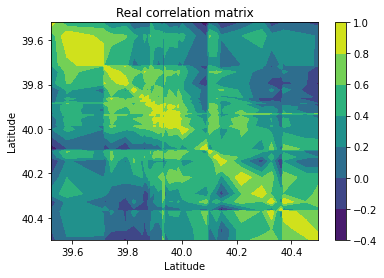

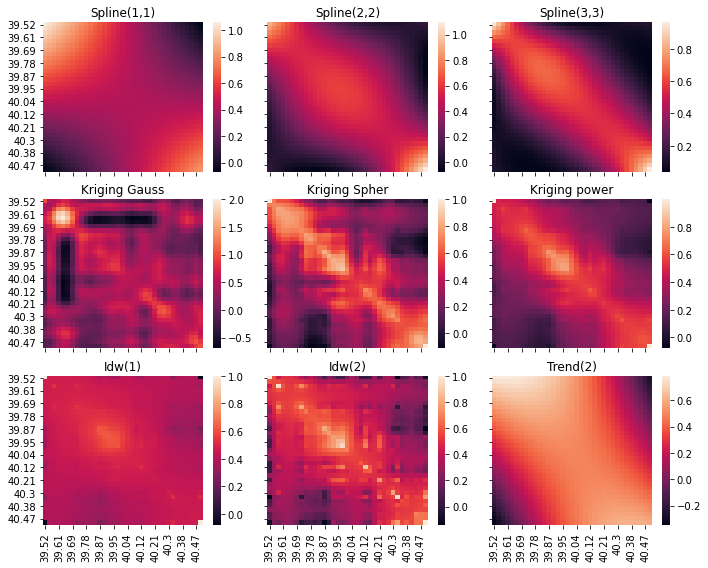

In [10]:
feature = 'Latitude'
x_real = loc_df[feature.lower()].values
x_uniform = np.linspace(x_real.min(), x_real.max(), 35)
X1_real, X2_real = np.meshgrid(x_real, x_real)
X1_uniform, X2_uniform = np.meshgrid(x_uniform, x_uniform)
X_real = np.array([(i,j) for i,j in zip(X1_real.ravel(), X2_real.ravel())])
X_uniform = np.array([(i,j) for i,j in zip(X1_uniform.ravel(), X2_uniform.ravel())])
tmp_df = pd.DataFrame(index=x_real, columns=x_real, data=multi_data.corr().values)
tmp_df = tmp_df.sort_index()
tmp_df = tmp_df[tmp_df.index.unique().tolist()]
x_real = np.array(sorted(loc_df[feature.lower()].values))
X1_real, X2_real = np.meshgrid(x_real, x_real)
plt.contourf(X1_real, X2_real, tmp_df.values)
plt.xlabel(feature);plt.ylabel(feature)
plt.gca().invert_yaxis()
plt.colorbar();plt.title('Real correlation matrix')

fig, ax = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
locs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
names = ['Spline(1,1)', 'Spline(2,2)', 'Spline(3,3)', 'Kriging Gauss', 'Kriging Spher', 'Kriging power',
         'Idw(1)', 'Idw(2)', 'Trend(2)']
for idx, model in enumerate([BSpline(1,1), BSpline(2,2), BSpline(3,3), Kriging(variogram_model='gaussian'),
                             Kriging(variogram_model='spherical'), Kriging(variogram_model='power'),
                             Idw(1), Idw(2), Trend(2)]):
    model.fit(X_real, multi_data.corr().values.ravel())
    Z_uniform = model.predict(X_uniform)
#     maped = ax[locs[idx]].contourf(X1_uniform, X2_uniform, Z_uniform.reshape(*X1_uniform.shape))
    tmp_df = pd.DataFrame(index=np.round(x_uniform,2), 
                          columns=np.round(x_uniform,2), 
                          data=Z_uniform.reshape(*X1_uniform.shape))
    sns.heatmap(tmp_df, ax=ax[locs[idx]])
#     ax[locs[idx]].set_xlabel(feature);ax[locs[idx]].set_ylabel(feature)
#     plt.colorbar(maped, ax=ax[locs[idx]]);
#     print(idx)
    names[idx]
    ax[locs[idx]].set_title(names[idx])
plt.tight_layout()